In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.notebook_config import *
import random
from utils.simulation import *

In [10]:
#This case: Large pool of TFs A,B,C, so we assume that p_a ,p_B and p_C are constant and both rna strings have the same probablilities. Also the unbound probabilities are the same as p_a, etc.


def simulation_dustin(probs: list, timesteps: int, shots: int):
    avg1, avg2, std1, std2 = [],[],[],[]
    total1, total2 = np.array([0 for i in range(timesteps)]), np.array([0 for i in range(timesteps)])

    avg_corr = np.array([[0,0],[0,0]])

    for z in range(shots):
        rna1 = [0,0,0]
        rna2 = [0,0,0]
        p_a, p_b, p_c, p_m1, p_m2, p_m3 = probs[0], probs[1], probs[2], probs[3], probs[4], probs[5]

        protein1, protein2 = [],[]                #amount of protein produced in every timestep

        for i in range(timesteps):

            prots1 = 0
            for i in rna1:
                if i != 0 and i != "M":
                    prots1 += 1
            protein1.append(prots1)
            prots2 = 0
            for i in rna2:
                if i != 0 and i != "M":
                    prots2 += 1
            protein2.append(prots2)

            order = np.random.permutation(6)       #random order
            for k in order:
                if k-3 < 0:
                    #########################        Check if empty --> Either A docks or M, depending on p_a/p_m
                    if k == 0 and rna1[k] == 0:
                        r1, r2 = random.random(), random.random()
                        if r1 <= p_a and r2 > p_m1:
                            rna1[k] = "A"
                            continue
                        elif r1 > p_a and r2 <= p_m1:
                            rna1[k] = "M"
                            continue
                    if k == 1 and rna1[k] == 0:
                        r1, r2 = random.random(), random.random()
                        if r1 <= p_a and r2 > p_m2:
                            rna1[k] = "B"
                            continue
                        elif r1 > p_a and r2 <= p_m2:
                            rna1[k] = "M"
                            continue
                    if k == 2 and rna1[k] == 0:
                        r1, r2 = random.random(), random.random()
                        if r1 <= p_a and r2 > p_m3:
                            rna1[k] = "C"
                            continue
                        elif r1 > p_a and r2 <= p_m3:
                            rna1[k] = "M"
                            continue
                    ###########################            Check if already A/B/C are docked --> undock depending p_a etc.
                    if k == 0 and rna1[k] == "A":
                        if random.random() <= p_a:
                            rna1[k] = 0
                            continue
                    if k == 1 and rna1[k] == "B":
                        if random.random() <= p_b:
                            rna1[k] = 0
                            continue
                    if k == 2 and rna1[k] == "C":
                        if random.random() <= p_c:
                            rna1[k] = 0
                            continue
                    #############################            Check for methylation --> un-methylize depending on p_m
                    if k == 0 and rna1[k] == "M":
                        if random.random() <= p_m1:
                            rna1[k] = 0
                            continue
                    if k == 1 and rna1[k] == "M":
                        if random.random() <= p_m2:
                            rna1[k] = 0
                            continue
                    if k == 2 and rna1[k] == "M":
                        if random.random() <= p_m3:
                            rna1[k] = 0
                            continue
                ############################################################### Do the same for the second rna!
                else:
                    k = k-3
                    if k == 0 and rna2[k] == 0:
                        r1, r2 = random.random(), random.random()
                        if r1 <= p_a and r2 > p_m1:
                            rna2[k] = "A"
                            continue
                        elif r1 > p_a and r2 <= p_m1:
                            rna2[k] = "M"
                            continue
                    if k == 1 and rna2[k] == 0:
                        r1, r2 = random.random(), random.random()
                        if r1 <= p_a and r2 > p_m2:
                            rna2[k] = "B"
                            continue
                        elif r1 > p_a and r2 <= p_m2:
                            rna2[k] = "M"
                            continue
                    if k == 2 and rna2[k] == 0:
                        r1, r2 = random.random(), random.random()
                        if r1 <= p_a and r2 > p_m3:
                            rna2[k] = "C"
                            continue
                        elif r1 > p_a and r2 <= p_m3:
                            rna2[k] = "M"
                            continue
                    ###########################            Check if already A/B/C are docked --> undock depending p_a etc.
                    if k == 0 and rna2[k] == "A":
                        if random.random() <= p_a:
                            rna2[k] = 0
                            continue
                    if k == 1 and rna2[k] == "B":
                        if random.random() <= p_b:
                            rna2[k] = 0
                            continue
                    if k == 2 and rna2[k] == "C":
                        if random.random() <= p_c:
                            rna2[k] = 0
                            continue
                    #############################            Check for methylation --> un-methylize depending on p_m
                    if k == 0 and rna2[k] == "M":
                        if random.random() <= p_m1:
                            rna2[k] = 0
                            continue
                    if k == 1 and rna2[k] == "M":
                        if random.random() <= p_m2:
                            rna2[k] = 0
                            continue
                    if k == 2 and rna2[k] == "M":
                        if random.random() <= p_m3:
                            rna2[k] = 0
                            continue
        total1 = np.vstack((total1, protein1))
        total2 = np.vstack((total2, protein2))
        avg_corr = avg_corr + np.corrcoef(protein1, protein2)
    total1 = np.delete(total1, (0), axis=0)
    total2 = np.delete(total2, (0), axis=0)
    for i in total1.T:
        avg1.append(np.mean(i))
        std1.append(np.std(i))
    for i in total2.T:
        avg2.append(np.mean(i))
        std2.append(np.std(i))
    avg_corr = avg_corr/shots
    time = [i for i in range(timesteps)]

    return time, avg1, std1, avg2, std2, avg_corr


In [11]:
probabilities  = np.random.rand(6)/5

time, avg1, std1, avg2, std2, avg_corr = simulation_dustin(probs=probabilities, timesteps=300, shots = 100)         

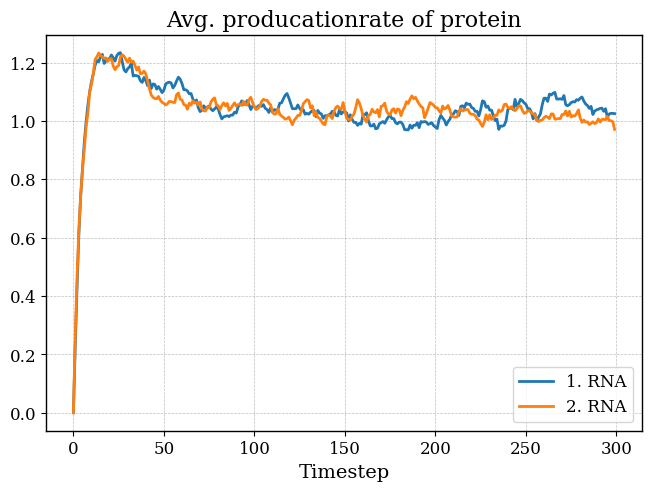

[[1.         0.01269826]
 [0.01269826 1.        ]]


In [12]:
probabilities = [0.08, 0.08, 0.08, 0.02, 0.02, 0.02]

time, avg1, std1, avg2, std2, avg_corr = simulation_dustin(probs=probabilities, timesteps=300, shots = 1000)   

plt.plot(time, avg1, label="1. RNA")
plt.plot(time, avg2, label="2. RNA")
plt.xlabel("Timestep")
plt.title("Avg. producationrate of protein")
plt.legend()
plt.show()

print(avg_corr)

In [3]:
#Work here with the defined classes in simulation2.py

p1 = 0.08

p2 = 0.02

# gene1 = gene(3, boxes, p1, p2)
# gene2 = gene(3, boxes, p1, p2)

simu = simulation(timesteps=200)

avg1, std1, avg2, std2, avg_corr = simu.average(3, p1, p2, 1000, m_switch=False)
avg1m, std1m, avg2m, std2m, avg_corrm = simu.average(3, p1, p2, 1000, m_switch=True)

In [2]:
n = 10

p1, p2 = 0.08, 0.02

simu = simulation(timesteps=200)

avg1_n, std1_n, avg2_n, std2_n, avg_corr_n = simu.average(n, p1, p2, 1000, m_switch=False)
avg1m_n, std1m_n, avg2m_n, std2m_n, avg_corrm_n = simu.average(n, p1, p2, 1000, m_switch=True)

In [ ]:
max_len = len(avg1_n)

def pad_list(lst, length):
    return lst + [0] * (length - len(lst))

avg_corr_n_padded = pad_list([avg_corr_n], max_len)
avg_corrm_n_padded = pad_list([avg_corrm_n], max_len)

cols = ["avg1", "std1", "avg2", "std2", "avg_corr", 
        "avg1m", "std1m", "avg2m", "std2m", "avg_corrm"]
header = "time\t" + "\t".join(f"{c}_{n}" for c in cols)

data_n = np.column_stack((simu.timeline, avg1_n, std1_n, avg2_n, std2_n, avg_corr_n_padded
                          , avg1m_n, std1m_n, avg2m_n, std2m_n, avg_corrm_n_padded ))

np.savetxt("data/length{}_corr.txt".format(n), data_n, fmt="%f", header=header, delimiter="\t")

In [4]:
data = np.loadtxt("data/length10_corr.txt", delimiter="\t", skiprows=1)

time       = data[:, 0]
avg1_10    = data[:, 1]
std1_10    = data[:, 2]
avg2_10    = data[:, 3]
std2_10    = data[:, 4]
avg_corr_10 = data[0, 5]

avg1m_10    = data[:, 6]
std1m_10    = data[:, 7]
avg2m_10    = data[:, 8]
std2m_10    = data[:, 9]
avg_corrm_10 = data[0, 10]


data = np.loadtxt("data/length30_corr.txt", delimiter="\t", skiprows=1)

time       = data[:, 0]
avg1_30    = data[:, 1]
std1_30    = data[:, 2]
avg2_30    = data[:, 3]
std2_30    = data[:, 4]
avg_corr_30 = data[0, 5]

avg1m_30    = data[:, 6]
std1m_30    = data[:, 7]
avg2m_30    = data[:, 8]
std2m_30    = data[:, 9]
avg_corrm_30 = data[0, 10]


data = np.loadtxt("data/length50_corr.txt", delimiter="\t", skiprows=1)

time       = data[:, 0]
avg1_50    = data[:, 1]
std1_50    = data[:, 2]
avg2_50    = data[:, 3]
std2_50    = data[:, 4]
avg_corr_50 = data[0, 5]

avg1m_50    = data[:, 6]
std1m_50    = data[:, 7]
avg2m_50    = data[:, 8]
std2m_50    = data[:, 9]
avg_corrm_50 = data[0, 10]

data = np.loadtxt("data/length100_corr.txt", delimiter="\t", skiprows=1)

time       = data[:, 0]
avg1_100    = data[:, 1]
std1_100   = data[:, 2]
avg2_100    = data[:, 3]
std2_100    = data[:, 4]
avg_corr_100 = data[0, 5]

avg1m_100    = data[:, 6]
std1m_100   = data[:, 7]
avg2m_100   = data[:, 8]
std2m_100    = data[:, 9]
avg_corrm_100 = data[0, 10]

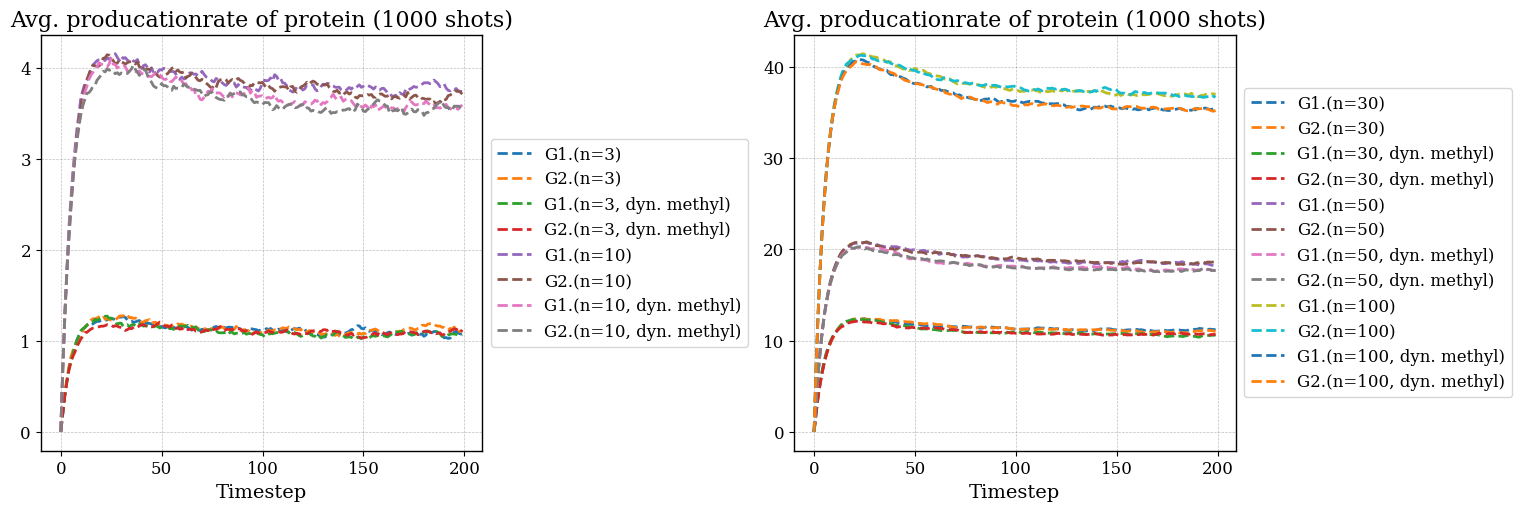

For 3 lattice sites:

Avg. Correlation bewteen the protein prodcution of each gene:  0.0038564094661336875
Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour):  0.004464894135376339

 For 10 lattice sites:

Avg. Correlation bewteen the protein prodcution of each gene:  0.010435
Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour):  0.009056

 For 30 lattice sites:

Avg. Correlation bewteen the protein prodcution of each gene:  0.026755
Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour):  0.023462

 For 50 lattice sites:

Avg. Correlation bewteen the protein prodcution of each gene:  0.035437
Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour):  0.033784

 For 100 lattice sites:

Avg. Correlation bewteen the protein prodcution of each gene:  0

In [5]:
time = simu.timeline

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))


ax1.plot(time, avg1, label="G1.(n=3)", linestyle="--")
ax1.plot(time, avg2, label="G2.(n=3)", linestyle="--")

ax1.plot(time, avg1m, label="G1.(n=3, dyn. methyl)", linestyle="--")
ax1.plot(time, avg2m, label="G2.(n=3, dyn. methyl)", linestyle="--")

ax1.plot(time, avg1_10, label="G1.(n=10)", linestyle="--")
ax1.plot(time, avg2_10, label="G2.(n=10)", linestyle="--")

ax1.plot(time, avg1m_10, label="G1.(n=10, dyn. methyl)", linestyle="--")
ax1.plot(time, avg2m_10, label="G2.(n=10, dyn. methyl)", linestyle="--")

ax2.plot(time, avg1_30, label="G1.(n=30)", linestyle="--")
ax2.plot(time, avg2_30, label="G2.(n=30)", linestyle="--")

ax2.plot(time, avg1m_30, label="G1.(n=30, dyn. methyl)", linestyle="--")
ax2.plot(time, avg2m_30, label="G2.(n=30, dyn. methyl)", linestyle="--")

ax2.plot(time, avg1_50, label="G1.(n=50)", linestyle="--")
ax2.plot(time, avg2_50, label="G2.(n=50)", linestyle="--")

ax2.plot(time, avg1m_50, label="G1.(n=50, dyn. methyl)", linestyle="--")
ax2.plot(time, avg2m_50, label="G2.(n=50, dyn. methyl)", linestyle="--")

ax2.plot(time, avg1_100, label="G1.(n=100)", linestyle="--")
ax2.plot(time, avg2_100, label="G2.(n=100)", linestyle="--")

ax2.plot(time, avg1m_100, label="G1.(n=100, dyn. methyl)", linestyle="--")
ax2.plot(time, avg2m_100, label="G2.(n=100, dyn. methyl)", linestyle="--")

ax1.set_xlabel("Timestep")
ax2.set_xlabel("Timestep")
ax1.set_title("Avg. producationrate of protein (1000 shots)")
ax2.set_title("Avg. producationrate of protein (1000 shots)")
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("figures/plot1.pdf")
plt.show()

print("For 3 lattice sites:\n")
print("Avg. Correlation bewteen the protein prodcution of each gene: ", avg_corr)
print("Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): ", avg_corrm)

print("\n For 10 lattice sites:\n")
print("Avg. Correlation bewteen the protein prodcution of each gene: ", avg_corr_10)
print("Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): ", avg_corrm_10)

print("\n For 30 lattice sites:\n")
print("Avg. Correlation bewteen the protein prodcution of each gene: ", avg_corr_30)
print("Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): ", avg_corrm_30)

print("\n For 50 lattice sites:\n")
print("Avg. Correlation bewteen the protein prodcution of each gene: ", avg_corr_50)
print("Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): ", avg_corrm_50)

print("\n For 100 lattice sites:\n")
print("Avg. Correlation bewteen the protein prodcution of each gene: ", avg_corr_100)
print("Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): ", avg_corrm_100)